### Libraries

In [1]:
import re
from math import log
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Question #1

There are four text files in the data folder

* Atatürk's "Nutuk" in Turkish
* Dicken's novel "Great Expectations" in English
* Flauberts' novel "Madam Bovary" in French
* A text file `unknown.txt` in an unknown language

Your tasks are

* Calculate how many times each character (letter) appear in each text.
* Calculate the character distributions, i.e. using the character counts, calculate the probability of each character appearing in the text.
* Find the set of characters common to all three texts.
* Using the common set and the KL-divergence, show that each language have different character distributions.
* Determine the language of the text file `unknown.txt` KL-divergence measure.

In [3]:
def text_counter(path):
    file=open(path,"r",encoding="utf-8-sig")
    text=file.read().lower()
    ansi_escape =re.compile(r'(\x7f|\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    text=ansi_escape.sub("",text)
    text=re.sub(r"[\W^0-9_]","","".join(text.split()))
    text_len=len(text)
    char_count={}
    for char in text:
        char_count[char]=char_count.get(char,0)+1
    char_dist={}
    for key in char_count.keys():
        char_dist[key]=char_count[key]/text_len
    return char_count,char_dist


In [4]:
ataturk_path="ataturk_nutuk.txt"
dickens_path="dickens_great_expectations.txt"
flaubert_path="flaubert_madame_bovary.txt"
unknown_path="unknown.txt"
common_chars=set(text_counter(ataturk_path)[0].keys()).intersection(set(text_counter(dickens_path)[0].keys()),
                                                                    set(text_counter(flaubert_path)[0].keys()),
                                                                    set(text_counter(unknown_path)[0].keys()))
common_chars

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y'}

In [5]:
unknown_dist=text_counter(unknown_path)[1]
def kl_divergence(paths,common_chars):
    data={"Nutuk":0,"Great Expectations":0,"Madame Bovary":0}
    df=pd.DataFrame(data,index=["Unknown"])
    for i,path in enumerate(paths):
        kl_div_result=sum([unknown_dist[key]*log(unknown_dist[key]/text_counter(path)[1][key]) for key in common_chars])
        df.iloc[0,i]=kl_div_result
    return df
paths=[ataturk_path,dickens_path,flaubert_path]
kl_divergence(paths,common_chars)

,Nutuk,Great Expectations,Madame Bovary
Unknown,0.536127,0.041943,0.276198


Unkwown text is written in the same language of Great Expectations.

## Question #2

For this question consider the [Car Evaluation Data Set](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) from UCI. Here is the [direct link](https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data) to the dataset.

Make [contingency tables](https://en.wikipedia.org/wiki/Contingency_table#:~:text=In%20statistics%2C%20a%20contingency%20table,%2C%20engineering%2C%20and%20scientific%20research.) of the columns (using [`crosstab`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) function from [pandas](https://pandas.pydata.org)) and figure out which pairs of columns are dependent and independent. Explain your result using statistical tests.

In [6]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data")
df.columns=["buying","maint","doors","persons","lug_boots","safety","acceptability"]
df.head()

,buying,maint,doors,persons,lug_boots,safety,acceptability
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [7]:
columns=list(df.columns)
for feature in columns:
    for feature2 in columns:
        if feature != feature2:
            ct=pd.crosstab(index=df[feature],columns=df[feature2])
            p=chi2_contingency(ct)[1]
            if p<0.05:
                print(feature,"and",feature2,"are dependent")
            else:
                print(feature,"and",feature2,"are independent")
    columns.remove(feature)

buying and maint are independent
buying and doors are independent
buying and persons are independent
buying and lug_boots are independent
buying and safety are independent
buying and acceptability are dependent
doors and maint are independent
doors and persons are independent
doors and lug_boots are independent
doors and safety are independent
doors and acceptability are independent
lug_boots and maint are independent
lug_boots and persons are independent
lug_boots and safety are independent
lug_boots and acceptability are dependent
acceptability and maint are dependent
acceptability and persons are dependent
acceptability and safety are dependent


## Question #3

For this question, use [Default of Credit Card Clients Data Set]() from UCI. Here is the [direct link](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls) to the dataset.

Your tasks are

* Inspect the dataset.
* Would it be appropriate to form a linear regression model to predict the `default payment next month` variable? Explain.
* Form a [contingency table](https://en.wikipedia.org/wiki/Contingency_table#:~:text=In%20statistics%2C%20a%20contingency%20table,%2C%20engineering%2C%20and%20scientific%20research.) of the columns `SEX` vs `default payment next month` and `EDUCATION` vs `default payment next month`.
* Are there statistically verifiable relationships between credit card defaults, the gender of and the education level the borrower? Which is stronger? Quantify your analysis using [Chi Square Test](https://en.wikipedia.org/wiki/Chi-squared_test).

In [8]:
df=pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
df["default payment next month"].unique()

array([1, 0], dtype=int64)

The default payment next month is a categorical variable. Therefore, it would not be appropriate to form a linear regression model.

In [10]:
cross_tab=pd.crosstab(index=df["SEX"],columns=df["default payment next month"])
print(cross_tab)
chi2_contingency(cross_tab)

default payment next month      0     1
SEX                                    
1                            9015  2873
2                           14349  3763


(47.70879689062111, 4.944678999412044e-12, 1, array([[ 9258.3744,  2629.6256],
        [14105.6256,  4006.3744]]))

In [11]:
cross_tab2=pd.crosstab(index=df["EDUCATION"],columns=df["default payment next month"])
print(cross_tab2)
chi2_contingency(cross_tab2)

default payment next month      0     1
EDUCATION                              
0                              14     0
1                            8549  2036
2                           10700  3330
3                            3680  1237
4                             116     7
5                             262    18
6                              43     8


(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

There is no correlation between "SEX" and "default payment next month". And also between "EDUCATION" and ""default payment next month" as well.

## Question #4

For this question, use the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) from UCI.  Here is the [direct link](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data) to the dataset.

Your tasks are

* Form a [K-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) model for this dataset.
* Test your model on random samples of your data and calculate its accuracy.
* Repeat your calculation 100 times and give an interval of accuracy values leaving the best 2.5% and worst 2.5% accuracy values.
* Is there a better way of doing this without repeating the calculation 100 times? Explain.
* Find the best parameter $k$ for your dataset for the K-NN model.

In [12]:
iris_df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",header=None)
columns=["sepal length","sepal width","petal length","petal width","class"]
iris_df.columns=columns
iris_df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [13]:
x=iris_df.iloc[:,0:4]
y=iris_df.iloc[:,4]
X_train, X_test, y_train, y_test = train_test_split(x,y,shuffle=True)

model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
result = pd.crosstab(y_test,y_pred)
print(result,"\n")

accuracy=accuracy_score(y_test,y_pred)
print(accuracy)

col_0            Iris-setosa  Iris-versicolor  Iris-virginica
class                                                        
Iris-setosa               15                0               0
Iris-versicolor            0                9               1
Iris-virginica             0                0              13 

0.9736842105263158


In [14]:
a=np.array([])
def NN_model(neighbors):
    X_train, X_test, y_train, y_test = train_test_split(x,y,shuffle=True)
    model = KNeighborsClassifier(n_neighbors=neighbors, metric='euclidean')
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    return accuracy_score(y_test,y_pred)
accuracy_list=[NN_model(3) for i in range(100)]
accuracy_list.sort()
accuracy_list[3:97][0],accuracy_list[3:97][-1]

(0.9210526315789473, 1.0)

Above we repeated the experiment 100 times to find interval of accuracy. If we only repeat the experiment 20 times we need to use t distribution:

In [15]:
accuracy_list=[NN_model(3) for i in range(20)]

a_mean=np.mean(accuracy_list)
a_std=np.std(accuracy_list,ddof=1)

t.interval(0.95, 19, loc=a_mean, scale=a_std)

(0.9179495290480761, 1.0083662604256078)

<function matplotlib.pyplot.show(*args, **kw)>

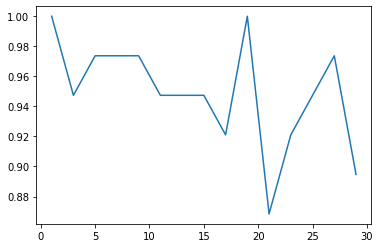

In [16]:
accuracy_list=[NN_model(n) for n in range(1,30,2)]
plt.plot(range(1,30,2),accuracy_list)
plt.show

## Question #5

For this question, we are going to use [Concrete Slump Test Dataset](https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test) from UCI. Here is the [direct link](https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data) to the dataset.

Your tasks are

* Form three separate linear regression model for the following dependent variables:

  - SLUMP (cm)
  - FLOW (cm)
  - 28-day Compressive Strength (Mpa)
  
* Compare how well these models fit.

In [17]:
concrete_df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data")
concrete_df.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [18]:
model1=LinearRegression()
model2=LinearRegression()
model3=LinearRegression()
x=concrete_df.iloc[:,1:8]


In [19]:
#prediction for SLUMP
y=concrete_df.iloc[:,8]
model1.fit(x,y)
model1.score(x,y)

0.32330787970835495

In [20]:
#prediction for FLOW
y=concrete_df.iloc[:,9]
model2.fit(x,y)
model2.score(x,y)

0.5022296725445192

In [21]:
#prediction for Compressive Strength
y=concrete_df.iloc[:,10]
model3.fit(x,y)
model3.score(x,y)

0.8968376098140092

Linear regression model best fits predicting 28-day Compressive Strength (Mpa).